# HON InfoMap Communities
Plotting communities found by InfoMap.

In [1]:
import matplotlib
#matplotlib.use('Agg')
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import signac
from util import fetch_geodata

project = signac.get_project()
job = project.find_jobs({"year": 2011, "quarter": 1}).next()

In [2]:
paths = pd.read_csv(job.fn('hon_infomap.tree'), sep=' ', header=None, skiprows=2, names=['path', 'flow', 'ID', 'node'])
paths['path'] = paths['path'].apply(lambda x: tuple(map(int, x.split(':'))))
paths = paths.sort_values('path')
iatas = pd.read_csv(job.fn('airport_codes.csv'))
iatas['ID'] = pd.to_numeric(iatas['ID'])
iatas = iatas.set_index('ID')
airports = pd.merge(iatas, fetch_geodata(), left_on='IATA', right_index=True)
paths = pd.merge(paths, airports, left_on='ID', right_index=True)
paths = paths.sort_values('path')
paths.head()

Reading airport geodata...


,path,flow,ID,node,IATA,name,lon,lat
0,"(1, 1, 1)",0.021922,11057,288,CLT,Charlotte Douglas International Airport,-80.943100,35.214001
1,"(1, 1, 2)",0.015708,14100,161,PHL,Philadelphia International Airport,-75.241096,39.871899
2,"(1, 1, 3)",0.011629,14122,466,PIT,Pittsburgh International Airport,-80.232903,40.491501
3,"(1, 1, 4)",0.005474,11278,172,DCA,Ronald Reagan Washington National Airport,-77.037697,38.852100
4,"(1, 1, 5)",0.002343,10721,298,BOS,General Edward Lawrence Logan International Ai...,-71.005203,42.364300


In [3]:
def plot_community(paths, community=None):
    print('Generating plot...')
    fig = plt.figure(figsize=(6, 4), dpi=100)
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
    ax.set_extent([-128, -64, 22, 49], ccrs.Geodetic())

    shapename = 'admin_1_states_provinces_shp'
    states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)

    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    plt.title('Communit{} from Higher-Order Network ({}Q{})'.format(
        'ies' if community is None else 'y ' + str(community),
        job.sp.year, job.sp.quarter))

    def colorize_state(geometry):
        facecolor = (0.9375, 0.9375, 0.8594)
        return {'facecolor': facecolor, 'edgecolor': 'black'}

    ax.add_geometries(
        shpreader.Reader(states_shp).geometries(),
        ccrs.PlateCarree(),
        styler=colorize_state)

    xs = paths.lon.values
    ys = paths.lat.values
    colors = paths.flow.values
    sizes = 10000*paths.flow.values
    

    dots = ax.scatter(xs, ys, transform=ccrs.PlateCarree(), c=colors, s=sizes, alpha=0.8, zorder=10,
                      norm=mcolors.LogNorm(vmin=1e-4, vmax=1e-1), cmap='viridis')

    top_n = paths.sort_values('flow', ascending=False).head(20).index
    for row in paths.loc[top_n].itertuples():
        ax.annotate(row.IATA, (row.lon, row.lat), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                    fontsize=40*row.flow**0.2, zorder=11, ha='center', va='center')
    cbax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    cbar = plt.colorbar(dots, cax=cbax)
    cbar.set_label('Flow through node', rotation=90)
    #plt.savefig(job.fn('hon_communities.png'))
    plt.show()
    plt.close()

In [4]:
def get_community(paths, community_path):
    if len(community_path) == 3:
        left = tuple([*community_path[:-1], community_path[-1]-1])
        right = tuple([*community_path[:-1], community_path[-1]+1])
    else:
        left = tuple([*community_path, *(-1,)*(3-len(community_path))])
        right = tuple([*community_path[:-1], community_path[-1]+1, *(0,)*(3-len(community_path))])
    return paths[paths.path.between(left, right)]

(1, 1) 0.1069477665118
Generating plot...


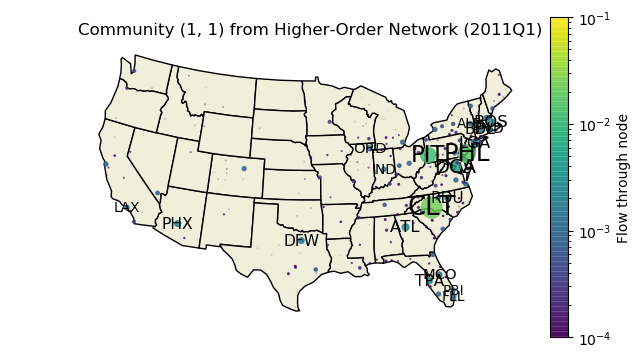

(1, 2) 0.070349340832
Generating plot...


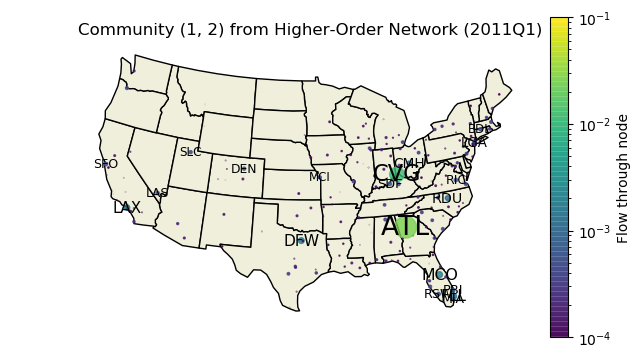

(1, 3) 0.058988804825699986
Generating plot...


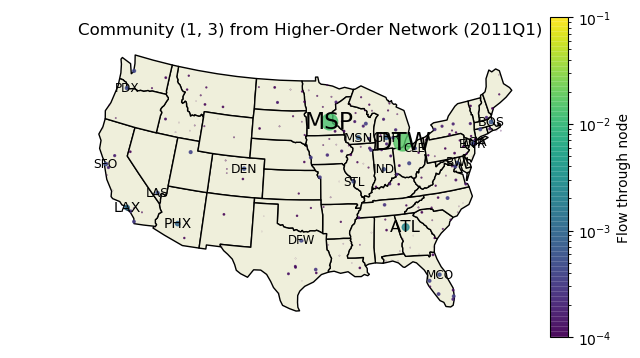

(1, 4) 0.039176544826000005
Generating plot...


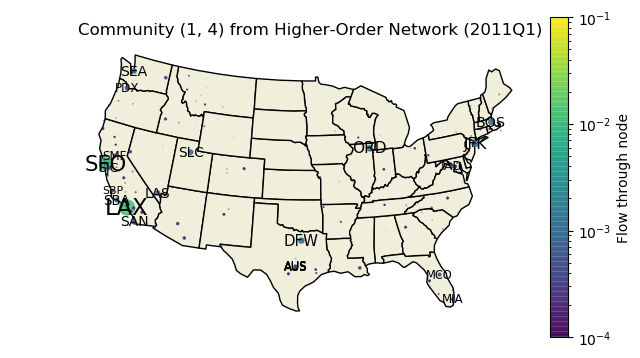

(1, 5) 0.04307792151569999
Generating plot...


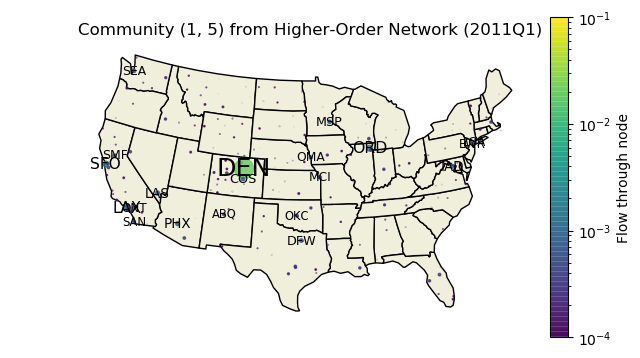

(1, 6) 0.03843833156900001
Generating plot...


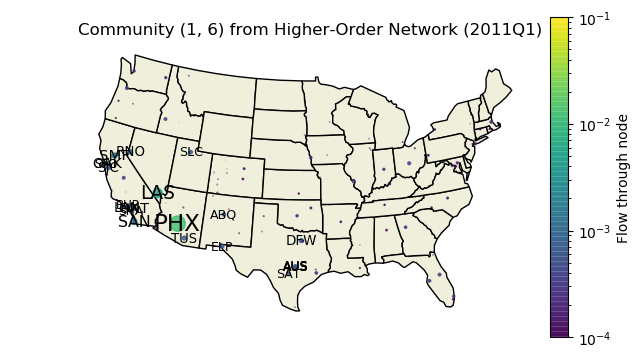

(1, 7) 0.036502097335999975
Generating plot...


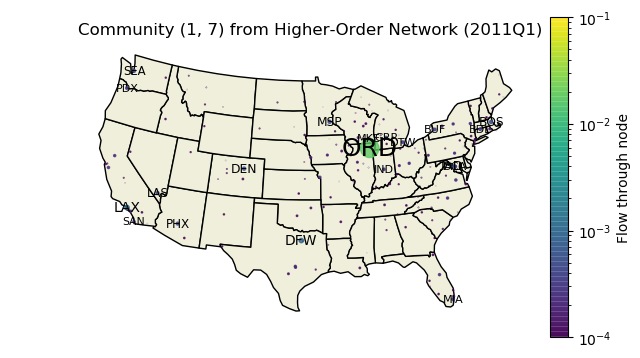

(1, 8) 0.028409810558999993
Generating plot...


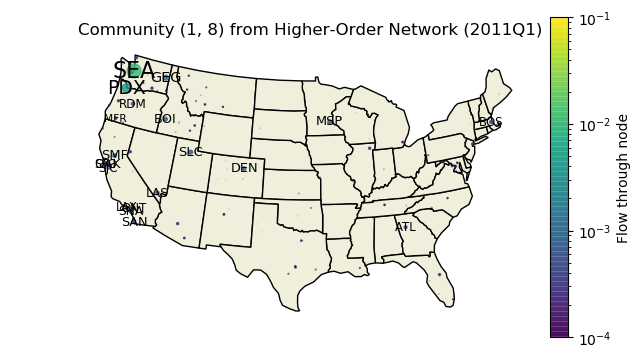

(1, 9) 0.03255053729800002
Generating plot...


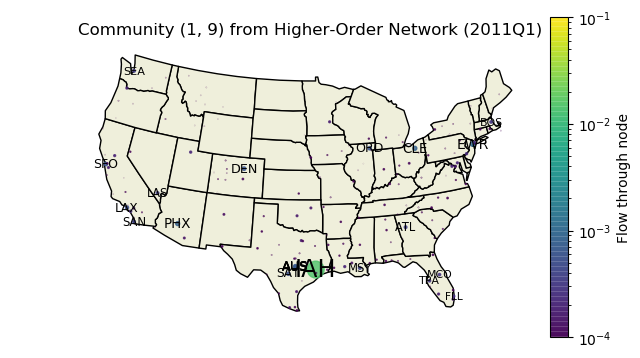

(1, 10) 0.03033404236250001
Generating plot...


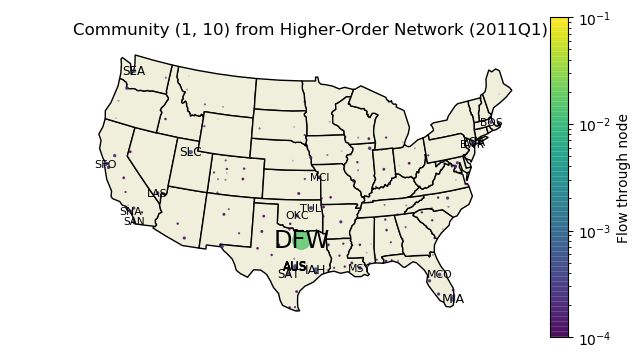

(1, 11) 0.01739229049100002
Generating plot...


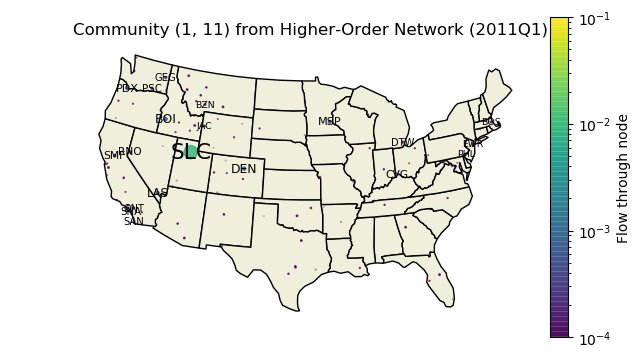

(1, 12) 0.017010756741
Generating plot...


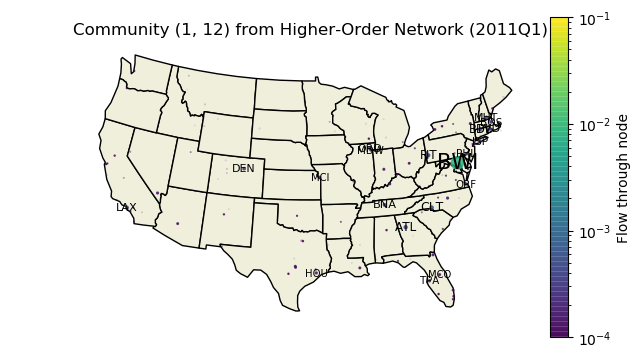

(1, 13) 0.01748744844299999
Generating plot...


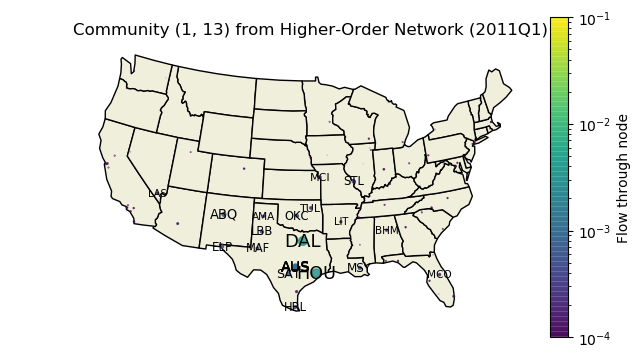

(1, 14) 0.015393894177500004
Generating plot...


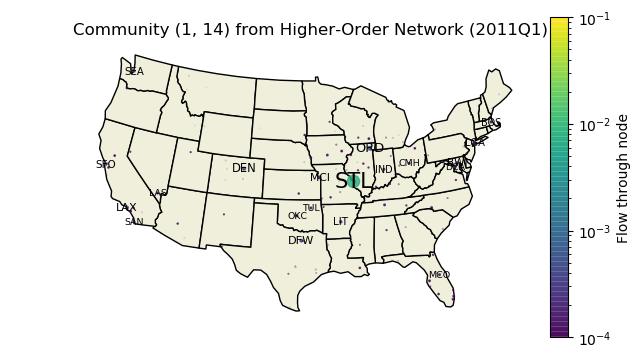

(1, 15) 0.014124386973000001
Generating plot...


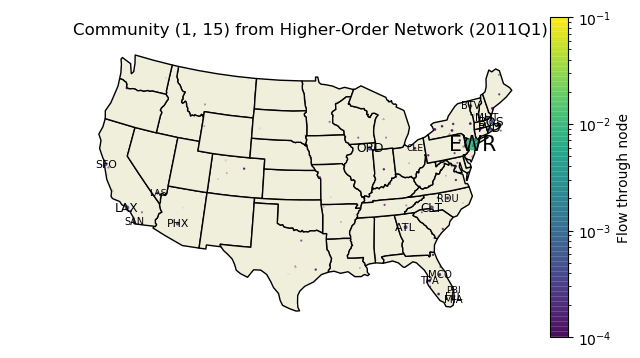

(1, 16) 0.014316768058999995
Generating plot...


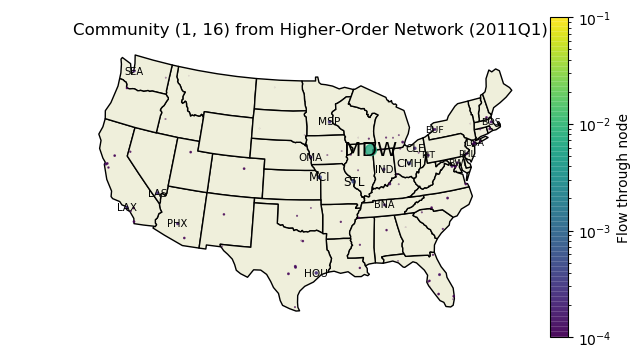

(1, 17) 0.012298056481000002
Generating plot...


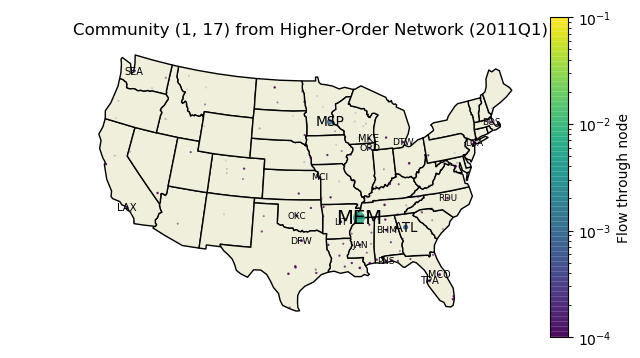

(1, 18) 0.010384264671999996
Generating plot...


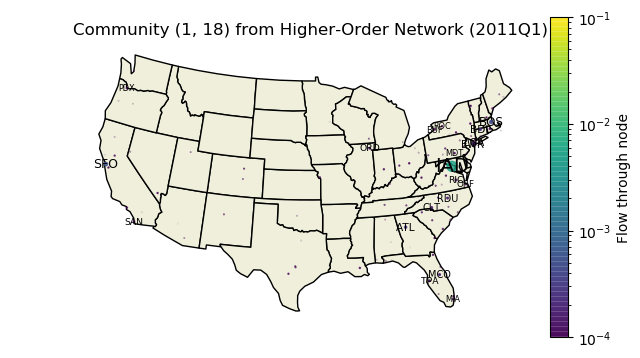

(1, 19) 0.009671375078899999
Generating plot...


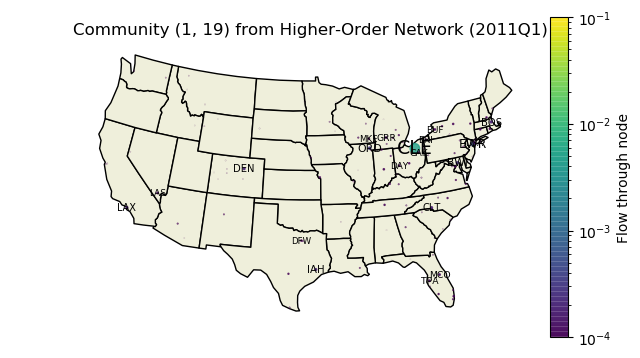

(1, 20) 0.007354522166999997
Generating plot...


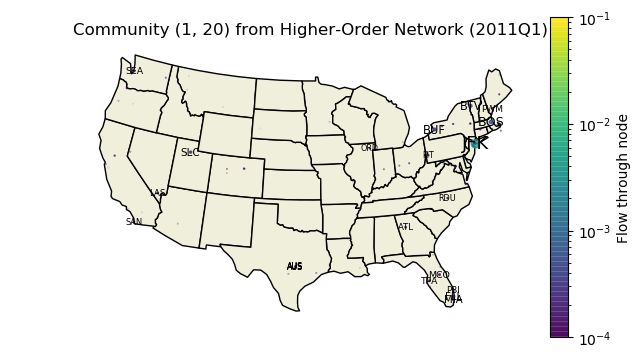

(1, 21) 0.007060868574199998
Generating plot...


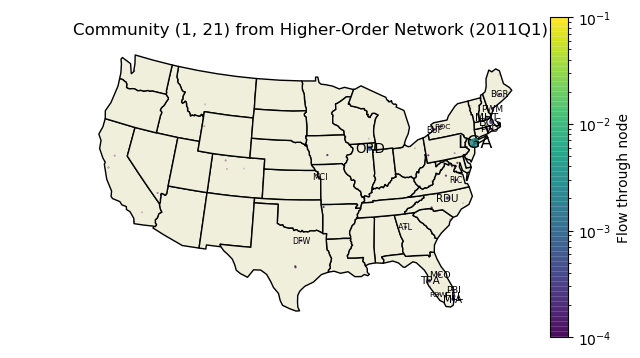

(1, 22) 0.0069970512289999984
Generating plot...


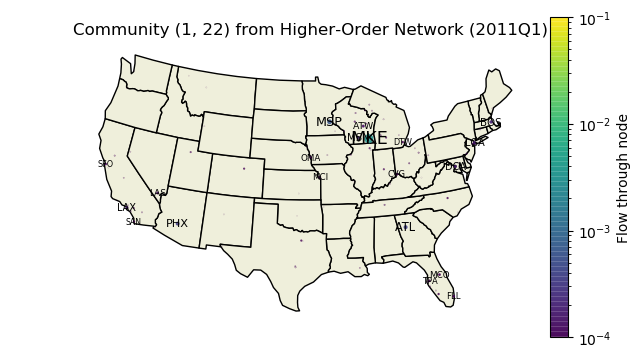

(1, 23) 0.006879212535999998
Generating plot...


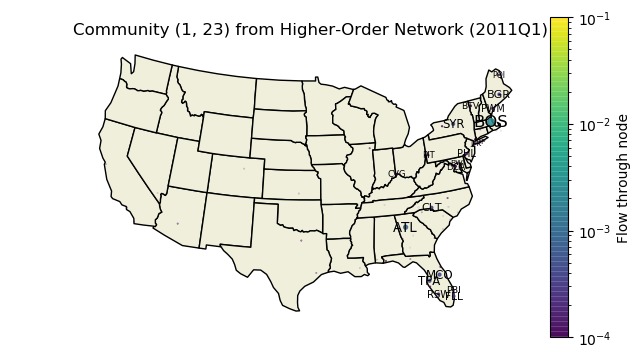

In [5]:
for community in paths.path.apply(lambda x: x[:2]).unique():
    data = get_community(paths, community)
    flow = sum(data.flow)
    if flow > 5e-3:
        print('{} {}'.format(community, flow))
        plot_community(data, community=community)

## Checking on other modules
We don't see any significant patterns for other modules.

(2,) 0.0005367433900000001
Generating plot...


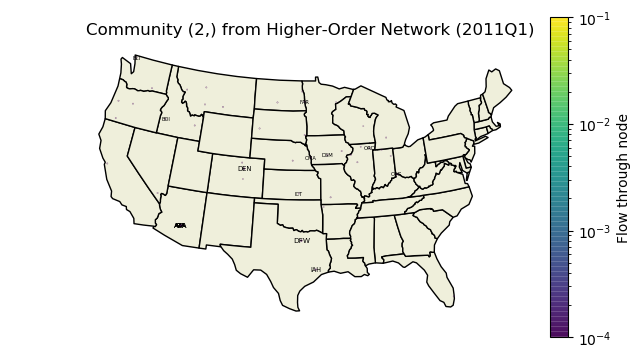

(3,) 0.0004180261100000001
Generating plot...


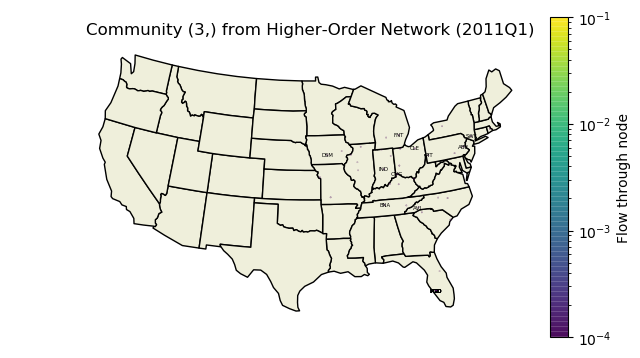

In [6]:
for community in [(2,), (3,)]:
    data = get_community(paths, community)
    flow = sum(data.flow)
    print('{} {}'.format(community, flow))
    plot_community(data, community=community)